# Assignment 1: Speech Production and Models 
#### EQ2321 Speech and Audio Signal Processing

Max. grade: 30

**Instructions for the deliverables**

Perform all (or as many as you can) of the tasks in this project assignment.
Summarize your results in a presentation style document. 
You are going to present your work to the course responsible or one of the teaching assistants (TA)
and it pays off to have a clear, well structured and brief document. Explicitly
state, on the slides, the problem numbers.
Include an algorithmic solution and/or numerical result and/or a graph illustrating your results.
Your Python code should be functioning and easy to read.

You have to send us you `Python` source code at least a day before the scheduled time for your
presentation. 
Use a naming convention for your files that is easy to understand and associate with a specific problem number. 
Be prepared to demo your own code on a personal or our computer.
Archive your files before sending them to us!

**Grading system**
Each correctly solved task brings you a certain amount of points.
The grade you get depends on the amount of points you accumulate and your ability to motivate your solutions during the presentation.
A passing grade corresponds to having 30\% and more of the total amount of points, while an excellent grade requires 85\% and more.
No points will be granted for a correct response if you cannot motivate your answer.

Keep in mind, when working in a group of two, that both people are expected to be able to make a complete presentation and answer questions related to all problems.
You may be graded differently depending on your responses.
The grade you get depends on the amount of correctly solved tasks and your ability to motivate the solutions during the presentation.

In our first experiment we study how low-pass filtering affects the speech signal. Load the files male44.wav and female44.wav. The speech is sampled at 44.1 kHz.

In [11]:
import pickle as pkl

male_fname="male44.wav"
female_fname="female44.wav"
assignment_file="assignment1.pkl"

def read_assignment_file(fname):
    with open(fname,"rb") as f:
        d=pkl.load(f)
    return d


d=read_assignment_file(assignment_file)
from scipy.io import wavfile
import numpy as np

def read_wav(fname):
    raw_data=wavfile.read(fname)
    return raw_data[1].astype(np.float32), raw_data[0]


# https://python-sounddevice.readthedocs.io/en/0.3.6/
# !pip install sounddevice

import sounddevice as sd

def play_wav(x,fs):
    sd.play(x.astype(np.int16),fs)


from scipy.signal import firwin,filtfilt
def lowpass(x,fc,fs=44100):
    """ x is the signal, 
        fc is the cuttoff frequency expressed in Hz, must be between [0,fs/2]
    """
    b = firwin(1024, fc,fs=fs)
    y = filtfilt(b,1,x)
    return y


### Question 1 (0.5 pts)


This is a test of intelligibility, i.e., how well we can understand what is spoken.

At what cut-off frequency do you start hearing what is said?

### Question 2 (0.5 pts)

At what cut-off frequency do you start to hear a degradation in overall speech quality?

In [14]:
xmale, fs = read_wav(male_fname)
xfemale, fs = read_wav(female_fname)

In [64]:
# Inteligibility
play_wav(lowpass(xmale,1000,fs=fs),fs)

In [58]:
play_wav(lowpass(xfemale,2500,fs=fs),fs)

In [66]:
# Degradation
play_wav(lowpass(xfemale,3000,fs=fs),fs)

In [79]:
play_wav(lowpass(xfemale,4000,fs=fs),fs)

### Question 3 (1 pts)

Why, do you think (you are allowed to speculate!), is a sampling frequency of 8 kHz used in plain old telephony services (POTS)? 

## Voiced and Unvoiced Speech Sounds (8 pts)

From a time plot, find voiced and unvoiced regions. Study the harmonic structure and envelope of the speech spectra corresponding to voiced and
unvoiced regions.

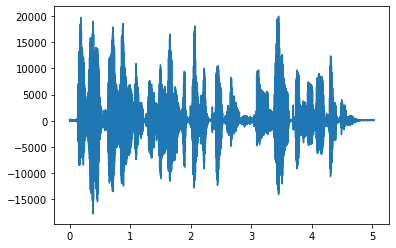

In [82]:
from scipy import signal
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt

### Question 1 (2 pts)

Create a time plot with voiced and unvoiced regions marked.

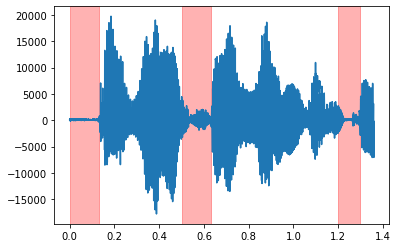

In [118]:
from scipy.io.wavfile import read
samplerate, data = read('male44.wav')
duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate) 

seg = 60000 # picked a window of 60k/rate ≃ 1.4s
plt.plot(time[1:seg],data[1:seg])
plt.axvspan(0, .13, color='red', alpha=0.3)
plt.axvspan(.5, .63, color='red', alpha=0.3)
plt.axvspan(1.2, 1.3, color='red', alpha=0.3)

plt.show()

### Question 2 (0.5 pts)

In the time plot, mark the regions where the pitch is the highest and the lowest. What are the approximate range of pitch frequencies in those regions?

In [ ]:
from scipy.io.wavfile import read
samplerate, data = read('male44.wav')
duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate) 

plt.plot(time,data)
plt.show()


### Question 3 (0.5 pts)

Plot the DFT based spectrum for a voiced frame using, the following snippet:

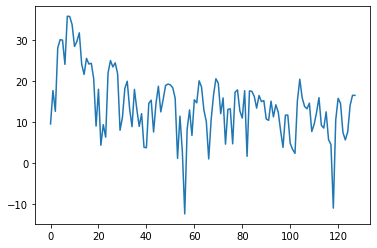

In [81]:
S = 0#... # Start of the frame
N = 256#... # Length of the frame

x = d["male_long"].reshape(-1)
xf = x[S:S+N]*signal.windows.hann(N)
X = fft(xf)
plt.figure()
plt.plot(10*np.log10(np.abs(X[1:N//2+1])**2))

### Question 4 (1 pts)

What is the mathematical expression of element `X[3]`, i.e.,
the third element in the FFT vector? What analog frequency (between
0-8000 Hz) does `X[3]` correspond to?


### Question 5 (0.5 pts)

What is the fundamental frequency (pitch) in your particular case?

### Question 6 (1 pts)

What frame length is appropriate? What compromise do you have to
make when choosing frame length?

### Question 7 (1 pts)

Replace the hanning window function with a rectangular window and compare the result.

### Question 8 (0.5 pts)

Extend the code above with the following lines to plot also the LP envelope of the short-time speech spectrum:

In [ ]:
from scipy.linalg import solve_toeplitz, toeplitz
def xcorr(x,y,M=10):
    """
    Perform Cross-Correlation on x and y
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation
    corr : coefficients of correlation
    """
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    idx=(lags>=-M) & (lags<=M)
    corr = corr[idx]
    lags=lags[idx]
    return lags[len(lags)//2:], corr[len(lags)//2:]

def get_envelop(xf,M,N=1024,fs=44100):

    lags, r = xcorr(xf, xf,M=M)

    a=np.concatenate([np.ones(1), solve_toeplitz(r[:-1], -r[1:])]).reshape(-1,1)
    e=(a.T @ r)[0]
    w, h2=signal.freqz(1,a,N,whole=True,fs=fs)
    
    X = fft(xf)
    fig,ax=plt.subplots(1,1)
    
    ax.plot(w[1:N//2+1],10*np.log10(np.abs(X[1:N//2+1])**2),label="$X(f)$")
    ax.plot(w[1:N//2+1],10*np.log10(e*np.abs(h2[1:N//2+1])**2),label="$Envelop$")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.legend()
    return fig,ax


# M is the prediction order
M = 10
fig,ax=get_envelop(xf,M,N=N,fs=fs)

### Question 9 (1 pts)

What is the mathematical expression of element `c(3)` (`corr(3)` in the `xcorr` function)? Why do we multiply `abs(h[1:N//2+1])**2` by `e` before plotting?

### Question 10 (1 pts)

What prediction order do you recommend? 

### Question 11 (0.5 pts)

Repeat the spectrum plotting for an unvoiced frame.

## Formants (2.5 pts)

In the speech variable “male short”, try to identify the vowels by comparing
the formants from an LP analysis to the formant frequencies of template vowels
in Table 1. Note that the table contains only the three first formants; you can
often see up to four formants.


|vowel|F1|F2|F3|example|
|:---:|:--:|:--:|:--:|:---:|
|iy|270|2290|3010|beet|
|ih|390|1990|2550|bit|
|eh|530|1840|2480|bet|
|ae|660|1720|2410|bat|
|ah|520|1190|2390|but|
|aa|730|1090|2240|hot|
|ao|570|840|2410|bought|
|uh|440|1020|2240|foot|
|uw|300|870|2240|boot|
|er|490|1350|1690|bird|

### Question 1 (1 pts)

In the time plot from the previous section, add the formant frequencies
and the vowels you come up with.

### Question 2 (1.5 pts)

How are pitch and formant frequencies related?

## Phonemes and Allophones (2.5 pts)

Vowels, which we studied in the previous section, constitute one class of phonemes.
Here we identify what other phonemes are contained in “male short”.

### Question 1 (1 pts)

In the time plot from the previous sections, mark the regions of the other phonemes and label each region with the correct phonetic symbol.

### Question 2 (1 pts)

Can consonants have formant frequencies?

### Question 3 (0.5 pts)

What is a diphthong?

### Question 4 (0.5 pts)

How many phonemes are there in English?

### Question 5 (0.5 pts)

What is a phone? What is an allophone? How many allophones are there?

## The Spectrogram (3 pts)

Program a spectrogram function in Python. A spectrogram shows the energy in speech as a function of time and frequency. The result is often displayed with time on the horizontal axis, and frequency on the vertical
axis. The energy (squared magnitude, and in dB) of the DFT coefficients are illustrated by e.g. a grayscale, where black corresponds to high energy, and white represents low energy. To obtain a smooth evolution over time,
we want to use overlapping analysis windows, see Figure 1. 
Test your function on the speech samples provided for this lab. For the presentation have the result for “male short” available.
<img src="./windowing.png" alt="alt text" width="400"/>

### Question 1 (0.5 pts)

First program a function that extracts overlapping frames and plots each frame. 
Input arguments should be update length, and analysis length.

Call `myspectrogram(x_short, 256, 32)` and view the animation. 

In [ ]:
%matplotlib auto
def myspectrogram(x, alen, ulen):
    """ x is the speech vector, 
    alen is the analysis frame length, 
    ulen is the update length"""
    N = len(x)
    naf = (N-alen+ulen)//ulen
    n1 = 0
    plt.figure()
    for n in range(0,naf):
        xf = x[n1:n1+alen]
        plt.cla()
        plt.plot(xf)
        plt.xlim([1,alen])
        plt.ylim([min(x),max(x)])
        plt.pause(0.05)
        n1 = n1 + ulen
myspectrogram(d["male_short"], 256, 32)

### Question 2 (0.5 pts)

Next add frequency analysis of each frame. Use the code for the DFT based spectrum from section 3 (dont forget to window before DFT). If you want to plot both the time domain signal, and the spectrum in the same plot, but in different parts of the window, see subplot. Illustrate the function as in the previous step.

### Question 3 (1 pts)

Now we are ready to implement the classical spectrogram. Instead of plotting the squared magnitude of the DFT, you put it into the columns of a matrix S. Preallocate the matrix with 
```python
S = np.zeros((alen//2+1, naf))
```
In the loop you write to column n by 

```python
S[:,n] = ...
```
In this assignment it is important that the right hand side is a column vector. To plot the spectrogram, use the following code:
```python

# type help gray for other colormaps
plt.imshow(np.flipud(-S), aspect="equal",cmap="gray"); # flipud flips S along the frequency axis so that
# frequencies increase when we move up the vertical axis
# -S makes black correspond to high energy!
```


### Question 4 (0.5 pts)

Produce a narrow-band spectrogram. Be prepared to indicate the fundamental frequency track, and the boundaries of the phonemes.

### Question 5 (0.5 pts)

Produce a wide-band spectrogram. Here the spectrogram tends to become blocky if smoothing is not performed in the frequency domain. Incorporate smoothing by zero-padding before applying the DFT. Can you see the
formant trajectories?

## Speech Parameter Estimation (5 pts)

In this section, you will analyze (estimate) the parameters of a vocoder model. In the next section you will synthesize speech based on the estimated parameters. The parameters we will estimate are frame energy, pitch, vocal tract filter coefficients, and voiced/unvoiced classification. The estimation should be done on a frame-by-frame basis and we will use overlapping analysis frames. Just as in the case of the spectrogram the choice of analysis frame length is a compromise between having long enough frames to get reliable estimates, but not too long so that rapid events are averaged out 2. Also as in the spectrogram case, the update length controls the smoothness of
the parameter trajectories over time.

### Question 1 (0.5 pts)

Let us warm up with estimation of frame energy (normalized per sample)
$E = \frac{1}{N_\alpha}\sum_{n=0}^{N_\alpha-1}x^2(n)$

where $N_\alpha$ is the analysis frame length and the sum is over the samples in one analysis frame. Write a function that returns the frame energies in a vector. Start with the function skeleton from the first task in section 6. Before the loop over all frames, allocate space for the vector of energies:

In [ ]:
def analysis(x, alen, ulen):
    naf = ...
    # Initialization
    E = np.zeros((naf, 1))
    # Inside loop
    E[n] = ...
    return E

### Question 2 (1 pts)

Next let us look at voiced/unvoiced detection. This is a difficult problem, but here we resolve to a simple solution based on zero-crossings. A zero
crossing occurs when $x(n)x(n − 1) < 0$. By counting all those occurrences within a frame, and normalizing by the frame length, a (near) continuous
parameter is obtained. To make a binary decision a threshold can be used (by normalizing with the frame length, the threshold becomes independent
(almost) of the analysis frame length). Extend your analysis function like:

In [ ]:
def analysis(x, alen, ulen):
    naf=...
    # Initialization
    E = np.zeros((naf, 1))
    ZC = np.zeros((naf, 1))
    V = np.zeros((naf, 1))
    
    # Inside loop
    E[n] = ...
    ZC[n] = ... # The normalized number of zero crossings
    V[n] = ... # Equal to 1 if voiced, 0 if unvoiced.
    return E, ZC, V

### Question 3 (0.5 pts)

Next extend your analysis function by incorporating code for vocal tract
filter estimation via LP analysis. The code from Section 3 should work
fine! Store the filter parameters in the rows of a matrix like:

In [ ]:
def analysis(x, alen, ulen, M):
    # Initialization
    E = np.zeros((naf, 1))
    ZC = np.zeros((naf, 1))
    V = np.zeros((naf, 1))
    A = np.zeros((naf, M+1)) # M is the prediction order.
    # M+1 allows space for the leading 1
    # Inside loop
    E[n] = ...
    ZC[n] = ... # The normalized number of zero crossings
    V[n] = ... # Equal to 1 if voiced, 0 if unvoiced.
    A[n,:] = ... # Make sure the polynomial coefficients are in a row vector
    return E, ZC, V, A


### Question 4 (0.5 pts)

Finally extend the function with pitch analysis. Many speech coding (compression) systems depend on accurate pitch analysis. Here we base our estimation on the correlation function of the frame. You may choose if you
wish to use the ACF or the normalized cross-correlation function (slightly more difficult to program). The problem you have to solve is how to find the lag of the peak in the ACF that corresponds to one pitch period. This is usually easy to do “manually”, i.e., by looking at the ACF, but you have to make the computer do it automatically! The function will finally look something like

In [ ]:
def analysis(x, alen, ulen, M):
    # Initialization
    E = np.zeros((naf, 1))
    ZC = np.zeros((naf, 1))
    V = np.zeros((naf, 1))
    A = np.zeros((naf, M+1)) # M is the prediction order.
    # M+1 allows space for the leading 1
    P = np.zeros((naf, 1))
    
    # Inside loop
    E[n] = ...
    ZC[n] = ... # The normalized number of zero crossings
    V[n] = ... # Equal to 1 if voiced, 0 if unvoiced.
    A[n,:] = ... # Make sure the polynomial coefficients are in a row vector!
    P[n] = ... # Pitch period in samples 
    return E, ZC, V, A, P

### Question 5 (0.5 pts)

Plot the output of your analysis function with the following code (or include the code below in the analysis function).
Test and tune your analysis function on the files “male long”, and “female
long”. Be prepared to provide plots with smooth temporal evolution, i.e., with ulen = 1.

In [ ]:
plt.figure()

plt.subplot(3,2,1)
plt.plot(x) # Plot the input waveform
plt.xlim([1, len(x)])
plt.ylim([np.min(x), np.max(x)])

plt.subplot(3,2,2)
plt.plot(np.sqrt(E)) # Plot the standard deviation
plt.xlim([1,len(E)])
plt.ylim([np.min(np.sqrt(E)),np.max(np.sqrt(E))])

plt.subplot(3,2,3)
plt.plot(V) # Plot voiced/unvoiced decision
plt.xlim([1, len(V)])
plt.ylim([0,1]);

plt.subplot(3,2,4)
plt.plot(ZC) # Plot the normalized number of zero-crossings
plt.xlim([1,len(ZC)])
plt.ylim([np.min(ZC),np.max(ZC)])

plt.subplot(3,2,5)
F = 8000./P
plt.plot(F) # Plot the fundamental frequency in Hz
plt.xlim([1,len(F)])
plt.ylim([0,600])

plt.subplot(3,2,6)
S = np.zeros(512, naf)
for n in range(0,naf):
    S[:,n] = 20*np.log10(np.abs(signal.freqz(1,A[n,:],512)))

S = np.flipud(S)
plt.imshow(S,cmap="gray"); # Illustrate the vocal tract envelope in a spectrogram style!

### Question 6 (1 pts)

What could make the voiced/unvoiced detection go wrong? 

### Question 7 (1 pts)

In the pitch estimation, what can cause pitch doubling? What can be the reason for pitch halving?

## Vocoder (5 pts)

In this section we will synthesize speech based on the parameters from the analysis. Speech coding (compression) systems based on this principle are called vocoders and can reach bit rates as low as 2 kbits/second when the parameters are quantized. This can be compared with 64 kbits/second for the PCM system used in fixed telephone networks. The quality of the vocoder is lower though. Here we will synthesize speech based on unquantized parameters.

### Question 1 (1 pts)

Let us start by only incorporating the vocal tract filter in the synthesis.
Make sure you use the same update length (ulen) in the synthesis as in the analysis! Make sure you understand why ulen samples are generated in the synthesis for each analysis frame 3.
Test with a pulse train excitation (use a constant pitch corresponding to 100 Hz). Then test with noise excitation. Can you hear what is said based on only vocal tract parameters (you may need to rescale the whole output
before playing back)?


Note:
You can also use the Python function `lfiltic` to implement the synthesis. But then you have to make sure that the final filter state after one frame is used as initial state in the next frame. The simple `filtfilt` function in Python is not designed for time-varying coefficients and audible clicks may result. To remedy this, see the function `filtic`. Another option is to implement the filter yourself. In that way you have full control over the filter memory. The downside is that your filter will probably execute slower than Python’s filter which is a built-in function.

Write a function like:

In [ ]:
def synthesis1(E, ZC, V, A, P, ulen):
    # We have included all the estimated parameters as input arguments but here we only use A!
    n_frames = A.shape[0] # Assuming filter coefficients are stored row-wise
    
    # Create a pulse train excitation:
    cp = ... # Constant pitch period in samples
    pexc = np.zeros((n_frames*ulen))
    pexc[0::cp] = 1
    
    # Create noise excitation:
    nexc = ...
    n1 = 0
    Z = np.array([])
    s = np.zeros((n_frames*ulen))
    
    for n in range(0, n_frames):   
        # Filter the excitation through the production (vocal tract) filter:      
        # Low pass filter
        if Z.shape[0] == 0: # 1st iteration
            s[n1:n1+ulen] = signal.lfilter(np.array([1]), A[n,:], pexc[n1:n1+ulen])
            Z = signal.lfiltic(np.array([1]), A[n,:], s[n1:n1+ulen], x=pexc[n1:n1+ulen])

        else:
            s[n1:n1+ulen],Z = signal.lfilter(np.array([1]), A[n,:], pexc[n1:n1+ulen], zi=Z)

        n1 = n1+ulen
    
    return s

### Question 2 (1 pts)

 Make sure the energy contour of the synthesized speech matches that of the original speech. A crude but simple way is to (re)normalize each synthesized frame to have frame energy $E(n)$.

Write a new function `synthesis2` (naturally based on `synthesis1`).
Test with the pulse and noise excitations from the previous task. How much does the energy contour contribute to the intelligibility?

Note: In the most straightforward energy normalization, a problem occurs when the synthesis
frame contains no pitch pulses (this will happen frequently if your update length is short).
Can you suggest a fix? It may require estimating the prediction residual energy (thus changing
also your analysis function slightly), and re-normalizing the excitation (before filtering) during
synthesis.

In [ ]:
def synthesis2(E, ZC, V, A, P, ulen):
    # add code here
    return s

### Question 3 (0.5 pts)

Switch between pulse excitation and noise excitation based on the voiced/
unvoiced decision, and write `synthesis3`.
Does this increase intelligibility? Our vocoder model assumes that all speech sounds are either voiced or unvoiced. Is this true? Discuss how our vocoder could be modified?


In [ ]:
def synthesis3(E, ZC, V, A, P, ulen):
    # add code here
    return s

### Question 4 (1 pts)

 Create a function `synthesis4` by adding time varying pitch! Now you cannot use the variable pexc anymore, but have to create the pulse train "on the fly".
One way is to keep a counter that is incremented for each sample during voiced frames.
When the counter equals or exceeds the current pitch value, a pulse is inserted into the excitation, and the counter is set to zero. The quality of the synthesized speech depends a lot on the quality of the pitch estimate.
Make sure the pitch contour is smooth in voiced regions.
If necessary you may median filter the pitch contour prior to synthesis.

In [ ]:
def synthesis4(E, ZC, V, A, P, ulen):
    # add code here
    return s

### Question 5 (1.5 pts)

Tune your analysis and synthesis functions so that the produced speech has as high quality as possible. We want to hear an exciting result! Please
make sure the vocoder output is readily available in a separate file when you come to present your results. 

hint: use scipy.io.wavfile.write() to save your .wav files